# Define

In [15]:
import datajoint as dj
schema = dj.schema('university')

In [16]:
@schema
class Student(dj.Manual):
    definition = """
    student_id : int unsigned   # university-wide ID number
    ---
    first_name      : varchar(40)
    last_name       : varchar(40)
    sex             : enum('F', 'M', 'U')
    date_of_birth   : date
    home_address    : varchar(120) # mailing street address
    home_city       : varchar(60)  # mailing address
    home_state      : char(2)      # US state acronym: e.g. OH
    home_zip        : char(10)     # zipcode e.g. 93979-4979
    home_phone      : varchar(20)  # e.g. 414.657.6883x0881
    """

In [17]:
@schema
class Department(dj.Manual):
    definition = """
    dept : varchar(6)   # abbreviated department name, e.g. BIOL
    ---
    dept_name    : varchar(200)  # full department name
    dept_address : varchar(200)  # mailing address
    dept_phone   : varchar(20)
    """

In [18]:
@schema
class StudentMajor(dj.Manual):
    definition = """
    -> Student
    ---
    -> Department
    declare_date :  date  # when student declared her major
    """

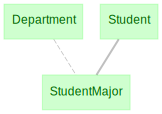

In [19]:
dj.Diagram(schema)

In [20]:
@schema
class Course(dj.Manual):
    definition = """
    -> Department
    course  : int unsigned   # course number, e.g. 1010
    ---
    course_name :  varchar(200)  # e.g. "Neurobiology of Sensation and Movement."
    credits     :  decimal(3,1)  # number of credits earned by completing the course
    """
    
@schema
class Term(dj.Manual):
    definition = """
    term_year : year
    term      : enum('Spring', 'Summer', 'Fall')
    """

@schema
class Section(dj.Manual):
    definition = """
    -> Course
    -> Term
    section : char(1)
    ---
    auditorium   :  varchar(12)
    """
    
@schema
class CurrentTerm(dj.Manual):
    definition = """
    -> Term
    """

@schema
class Enroll(dj.Manual):
    definition = """
    -> Student
    -> Section
    """

@schema
class LetterGrade(dj.Manual):
    definition = """
    grade : char(2)
    ---
    points : decimal(3,2)
    """

@schema
class Grade(dj.Manual):
    definition = """
    -> Enroll
    ---
    -> LetterGrade
    """

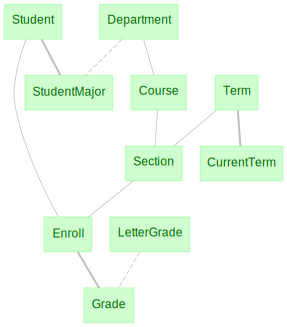

In [21]:
dj.Diagram(schema)

In [22]:
from tqdm import tqdm
import faker
import random
import itertools
import datetime
fake = faker.Faker()

In [23]:
def yield_students():
    fake_name = {'F': fake.name_female, 'M': fake.name_male}
    while True:  # ignore invalid values
        try:
            sex = random.choice(('F', 'M'))
            first_name, last_name = fake_name[sex]().split(' ')[:2]
            street_address, city = fake.address().split('\n')
            city, state = city.split(', ')
            state, zipcode = state.split(' ')            
        except ValueError:
            continue
        else:
            yield dict(
                first_name=first_name,
                last_name=last_name,
                sex=sex,
                home_address=street_address,
                home_city=city,
                home_state=state,
                home_zip=zipcode,
                date_of_birth=str(
                    fake.date_time_between(start_date="-35y", end_date="-15y").date()),
                home_phone = fake.phone_number()[:20])

In [24]:
Student.insert(
    dict(k, student_id=i) for i, k in zip(range(100,300), yield_students()))

In [25]:
Student()

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Joseph,Zhang,M,2001-01-02,279 Rosales Cliff,Port Stephenborough,ND,12880,281-421-2992
101,Chad,Gillespie,M,1998-05-10,0221 Scott Mission,West Jay,SD,23663,367.812.6252x85610
102,Laura,Peterson,F,1995-09-08,8186 Martin Square Apt. 094,Gordonport,MH,27930,+1-717-434-6599x2291
103,Xavier,Jones,M,2002-02-26,4352 Elijah Corner Suite 641,Richardshire,CO,14968,(553)733-9105x51636
104,Kimberly,Hansen,F,2007-12-17,8503 Paul Port,Hugheschester,KS,84271,001-971-761-9372x069
105,Joanna,Rojas,F,1994-01-14,4886 Hardy Coves Apt. 297,Chloeview,WV,34746,(557)800-7496
106,Sarah,Greer,F,2006-01-25,57306 Brown Lights,Amandashire,HI,03643,367-226-8446x84376
107,Shane,Raymond,M,1989-08-23,825 Stephen Dale,Richfort,ME,58044,(512)521-8342x97955
108,Katie,Massey,F,2006-06-09,2209 Hancock Street Apt. 348,West Jefferyburgh,PW,33369,(252)763-8620x0811
109,Jasmine,Crawford,F,1994-10-18,45512 West Rapid Apt. 164,North Patrick,MI,43070,(809)348-5386x416


In [26]:
Department.insert(
    dict(dept=dept, 
         dept_name=name, 
         dept_address=fake.address(), 
         dept_phone=fake.phone_number()[:20])
    for dept, name in [
        ["CS", "Computer Science"],
        ["BIOL", "Life Sciences"],
        ["PHYS", "Physics"],
        ["MATH", "Mathematics"]])

In [27]:
StudentMajor.insert({**s, **d, 
                     'declare_date':fake.date_between(start_date=datetime.date(1999,1,1))}
    for s, d in zip(Student.fetch('KEY'), random.choices(Department.fetch('KEY'), k=len(Student())))
                   if random.random() < 0.75)

In [28]:
StudentMajor()

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL",declare_date when student declared her major
101,MATH,1999-05-14
102,PHYS,2006-05-23
105,PHYS,2011-02-25
106,MATH,2023-03-11
108,MATH,2009-11-15
109,CS,2002-12-18
110,BIOL,2002-02-28
111,BIOL,2017-08-24
112,PHYS,2001-12-25
113,BIOL,2014-09-03


In [29]:
# from https://www.utah.edu/
Course.insert([
    ['BIOL', 1006, 'World of Dinosaurs', 3],
    ['BIOL', 1010, 'Biology in the 21st Century', 3],
    ['BIOL', 1030, 'Human Biology', 3],
    ['BIOL', 1210, 'Principles of Biology', 4],
    ['BIOL', 2010, 'Evolution & Diversity of Life', 3],
    ['BIOL', 2020, 'Principles of Cell Biology',  3],
    ['BIOL', 2021, 'Principles of Cell Science',  4],
    ['BIOL', 2030, 'Principles of Genetics',  3],
    ['BIOL', 2210, 'Human Genetics',3],
    ['BIOL', 2325, 'Human Anatomy', 4],
    ['BIOL', 2330, 'Plants & Society', 3],
    ['BIOL', 2355, 'Field Botany', 2],
    ['BIOL', 2420, 'Human Physiology', 4],

    ['PHYS', 2040, 'Classcal Theoretical Physics II', 4],
    ['PHYS', 2060, 'Quantum Mechanics', 3],
    ['PHYS', 2100, 'General Relativity and Cosmology', 3],
    ['PHYS', 2140, 'Statistical Mechanics', 4],
    
    ['PHYS', 2210, 'Physics for Scientists and Engineers I', 4], 
    ['PHYS', 2220, 'Physics for Scientists and Engineers II', 4],
    ['PHYS', 3210, 'Physics for Scientists I (Honors)', 4],
    ['PHYS', 3220, 'Physics for Scientists II (Honors)', 4],
    
    ['MATH', 1250, 'Calculus for AP Students I', 4],
    ['MATH', 1260, 'Calculus for AP Students II', 4],
    ['MATH', 1210, 'Calculus I', 4],
    ['MATH', 1220, 'Calculus II', 4],
    ['MATH', 2210, 'Calculus III', 3],
 
    ['MATH', 2270, 'Linear Algebra', 4],
    ['MATH', 2280, 'Introduction to Differential Equations', 4],
    ['MATH', 3210, 'Foundations of Analysis I', 4],
    ['MATH', 3220, 'Foundations of Analysis II', 4],
    
    ['CS', 1030, 'Foundations of Computer Science', 3],
    ['CS', 1410, 'Introduction to Object-Oriented Programming', 4],
    ['CS', 2420, 'Introduction to Algorithms & Data Structures', 4],
    ['CS', 2100, 'Discrete Structures', 3],
    ['CS', 3500, 'Software Practice', 4],
    ['CS', 3505, 'Software Practice II', 3],
    ['CS', 3810, 'Computer Organization', 4],
    ['CS', 4400, 'Computer Systems', 4],
    ['CS', 4150, 'Algorithms', 3],
    ['CS', 3100, 'Models of Computation', 3],
    ['CS', 3200, 'Introduction to Scientific Computing', 3],
    ['CS', 4000, 'Senior Capstone Project - Design Phase', 3],
    ['CS', 4500, 'Senior Capstone Project', 3],
    ['CS', 4940, 'Undergraduate Research', 3],
    ['CS', 4970, 'Computer Science Bachelor''s Thesis', 3]])

In [30]:
Term.insert(dict(term_year=year, term=term) 
            for year in range(1999, 2019) 
            for term in ['Spring', 'Summer', 'Fall'])

Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]

CurrentTerm().insert1({
    **Term().fetch(order_by=('term_year DESC', 'term DESC'), as_dict=True, limit=1)[0]})

def make_section(prob):
    for c in (Course * Term).proj():
        for sec in 'abcd':
            if random.random() < prob:
                break
            yield {
                **c, 'section': sec, 
                'auditorium': random.choice('ABCDEF') + str(random.randint(1,100))}   

Section.insert(make_section(0.5))

In [31]:
LetterGrade.insert([
    ['A',  4.00],
    ['A-', 3.67],
    ['B+', 3.33],
    ['B',  3.00],
    ['B-', 2.67],
    ['C+', 2.33],
    ['C',  2.00],
    ['C-', 1.67],
    ['D+', 1.33],
    ['D',  1.00],
    ['F',  0.00]])

In [32]:
LetterGrade()

grade,points
A,4.00
A-,3.67
B,3.00
B-,2.67
B+,3.33
C,2.00
C-,1.67
C+,2.33
D,1.00
D+,1.33


In [33]:
# Enrollment 
terms = Term().fetch('KEY')
quit_prob = 0.1
for student in tqdm(Student.fetch('KEY')):
    start_term = random.randrange(len(terms))
    for term in terms[start_term:]:
        if random.random() < quit_prob:
            break
        else:
            sections = ((Section & term) - (Course & (Enroll & student))).fetch('KEY')
            if sections:
                Enroll.insert({**student, **section} for section in 
                              random.sample(sections, random.randrange(min(5, len(sections)))))

100%|██████████| 200/200 [00:34<00:00,  5.85it/s]


In [34]:
# assign random grades
grades = LetterGrade.fetch('grade')

grade_keys = Enroll.fetch('KEY')
random.shuffle(grade_keys)
grade_keys = grade_keys[:len(grade_keys)*9//10]

Grade.insert({**key, 'grade':grade} 
             for key, grade in zip(grade_keys, random.choices(grades, k=len(grade_keys))))

# Queries

## Restriction

In [36]:
# Students from Texas
Student & {'home_state': 'TX'}

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
134,Nicholas,Clark,M,2005-10-01,88009 Deanna Station Suite 834,West Davidshire,TX,41171,+1-402-506-4715


In [37]:
Student & 'home_state="TX"'

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
134,Nicholas,Clark,M,2005-10-01,88009 Deanna Station Suite 834,West Davidshire,TX,41171,+1-402-506-4715


In [38]:
# Male students from outside Texas
(Student & 'sex="M"') - {'home_state': 'TX'}

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Joseph,Zhang,M,2001-01-02,279 Rosales Cliff,Port Stephenborough,ND,12880,281-421-2992
101,Chad,Gillespie,M,1998-05-10,0221 Scott Mission,West Jay,SD,23663,367.812.6252x85610
103,Xavier,Jones,M,2002-02-26,4352 Elijah Corner Suite 641,Richardshire,CO,14968,(553)733-9105x51636
107,Shane,Raymond,M,1989-08-23,825 Stephen Dale,Richfort,ME,58044,(512)521-8342x97955
110,Kevin,Peterson,M,2005-01-29,20568 King Inlet Suite 635,South Steven,IN,15195,818.327.9787
114,Jeremy,Benton,M,1990-10-25,25556 Robertson Flats,North John,AK,44145,(690)759-5744x16317
119,Chase,Johnson,M,2005-09-03,202 Burgess Crossing,North Justin,OK,96035,+1-620-999-6880x3575
123,William,Rodgers,M,2000-04-12,90264 Madeline Junction,Deckerton,WV,19442,321.336.4131
125,Derrick,Stone,M,2004-11-26,111 Brian Radial,Hernandezhaven,MS,54548,(545)591-8164x804
127,Mr.,Michael,M,2000-09-08,5247 Lindsey Inlet Suite 685,Ayalashire,OH,55972,001-730-783-9938x244


In [39]:
# Students from TX, OK, or NM
Student & [{'home_state':'OK'}, {'home_state':'NM'}, {'home_state':'TX'}] 

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
115,Phyllis,Morales,F,2001-03-08,0179 Krystal Camp Apt. 810,Tylerfurt,OK,13833,497-544-8639x753
117,Veronica,Murphy,F,1999-10-16,6152 David Harbors,Diazhaven,OK,72047,(930)510-0172x216
119,Chase,Johnson,M,2005-09-03,202 Burgess Crossing,North Justin,OK,96035,+1-620-999-6880x3575
126,Michelle,Mcdonald,F,2003-07-22,5251 Nguyen Rapid,Nicoleburgh,OK,33776,743.614.0026
134,Nicholas,Clark,M,2005-10-01,88009 Deanna Station Suite 834,West Davidshire,TX,41171,+1-402-506-4715
186,Steven,Nelson,M,1996-09-29,99590 Harris Village Suite 580,North Victorborough,OK,70973,726-258-3012
264,Alison,Lambert,F,2007-12-31,35399 Wilson Manors Suite 149,North Williamside,OK,11190,+1-914-282-1821x171
283,Andrea,Maddox,F,2001-08-09,3715 Smith Course,Donnaside,NM,03379,(404)935-2847x7302


In [40]:
# Millenials
millennials = Student & 'date_of_birth between "1981-01-01" and "1996-12-31"'

In [ ]:
millennials

In [41]:
# Students who have taken classes
Student & Enroll

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Joseph,Zhang,M,2001-01-02,279 Rosales Cliff,Port Stephenborough,ND,12880,281-421-2992
101,Chad,Gillespie,M,1998-05-10,0221 Scott Mission,West Jay,SD,23663,367.812.6252x85610
102,Laura,Peterson,F,1995-09-08,8186 Martin Square Apt. 094,Gordonport,MH,27930,+1-717-434-6599x2291
105,Joanna,Rojas,F,1994-01-14,4886 Hardy Coves Apt. 297,Chloeview,WV,34746,(557)800-7496
106,Sarah,Greer,F,2006-01-25,57306 Brown Lights,Amandashire,HI,03643,367-226-8446x84376
107,Shane,Raymond,M,1989-08-23,825 Stephen Dale,Richfort,ME,58044,(512)521-8342x97955
109,Jasmine,Crawford,F,1994-10-18,45512 West Rapid Apt. 164,North Patrick,MI,43070,(809)348-5386x416
111,Kelly,Hoffman,F,1991-12-16,587 Brooks Plaza Suite 371,Russellborough,WV,41026,293.925.2691x864
112,Alicia,Olson,F,1995-07-26,8944 Hood Highway,Mooremouth,KY,20754,989-331-9747x659
113,Katie,Davis,F,1999-12-15,843 Thomas Lane Suite 599,Matthewton,IN,62019,001-506-288-6610


In [42]:
# Millenials who have never enrolled
millennials - Enroll

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
143,Tony,Simpson,M,1991-09-10,0901 Angela Parks,South Angelahaven,MD,06465,+1-822-459-3634x513
176,Jessica,Hunter,F,1995-08-19,6459 Walker Fall Apt. 683,Susanstad,NC,58056,945.328.8843x523
244,Christopher,Evans,M,1989-09-29,680 Dominique Circle Apt. 075,Lake Anthony,MD,81162,001-577-610-6402
294,Tracy,Jackson,F,1990-12-07,6490 Schultz Crossroad Apt. 222,Dickersonmouth,VI,02009,001-788-751-5451


In [43]:
# Students who have not taken classes
Student - Enroll

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
103,Xavier,Jones,M,2002-02-26,4352 Elijah Corner Suite 641,Richardshire,CO,14968,(553)733-9105x51636
104,Kimberly,Hansen,F,2007-12-17,8503 Paul Port,Hugheschester,KS,84271,001-971-761-9372x069
108,Katie,Massey,F,2006-06-09,2209 Hancock Street Apt. 348,West Jefferyburgh,PW,33369,(252)763-8620x0811
110,Kevin,Peterson,M,2005-01-29,20568 King Inlet Suite 635,South Steven,IN,15195,818.327.9787
143,Tony,Simpson,M,1991-09-10,0901 Angela Parks,South Angelahaven,MD,06465,+1-822-459-3634x513
156,Anthony,Gordon,M,2008-07-08,1328 Herring Shoal Suite 523,Stricklandborough,PA,74301,001-672-628-0271x956
157,Kimberly,Jordan,F,1997-05-13,340 Turner Roads Apt. 851,Colemanside,DE,37391,(970)772-7907
163,Kristi,Wilson,F,2007-08-26,724 Clark Harbor Suite 584,New Lisa,MT,22201,+1-880-597-3483x2464
167,Amy,Watson,F,2006-03-05,916 Dickson Orchard Apt. 446,Laurenside,NJ,18957,(926)650-8280x785
176,Jessica,Hunter,F,1995-08-19,6459 Walker Fall Apt. 683,Susanstad,NC,58056,945.328.8843x523


In [44]:
# Students who have taken Biology classes but no MATH courses
(Student & (Enroll & 'dept="BIOL"')) - (Enroll & 'dept="MATH"')

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
116,Jennifer,Dixon,F,2003-11-22,091 Johnson Corners Apt. 490,South Shirleyborough,CO,93907,279-582-4940x0814
123,William,Rodgers,M,2000-04-12,90264 Madeline Junction,Deckerton,WV,19442,321.336.4131
132,Eduardo,Salazar,M,1998-02-14,7551 Fuller Well,New Louis,MS,82665,(339)952-2521x17040
136,Latoya,Monroe,F,1992-06-25,42143 Rachel Prairie Suite 361,Cainburgh,NH,64649,777.263.6298
138,Aaron,Jones,M,1995-04-04,80133 Martinez Bypass Suite 837,Elizabethberg,PW,94321,(993)964-3108x081
140,Teresa,Thornton,F,2000-10-31,972 Morgan Spurs Apt. 970,Lake Michaelbury,WY,94641,394-488-6882x305
141,Kimberly,Miller,F,1994-04-25,917 Denise Parkways Suite 171,Calderonchester,FL,69035,379.632.4508x7961
151,Jacqueline,Smith,F,2001-04-15,7199 Baker Light Apt. 368,Mooreport,CO,90892,001-723-255-7672
153,Samuel,Reyes,M,2001-05-11,254 Mark Way,Whitneyview,HI,53142,273-795-9329x084
154,Mitchell,Wallace,M,1989-10-07,21421 Susan Burgs,Jamesborough,NV,36141,564-722-2494x1742


In [45]:
# Students who have not selected a major
Student - StudentMajor

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Joseph,Zhang,M,2001-01-02,279 Rosales Cliff,Port Stephenborough,ND,12880,281-421-2992
103,Xavier,Jones,M,2002-02-26,4352 Elijah Corner Suite 641,Richardshire,CO,14968,(553)733-9105x51636
104,Kimberly,Hansen,F,2007-12-17,8503 Paul Port,Hugheschester,KS,84271,001-971-761-9372x069
107,Shane,Raymond,M,1989-08-23,825 Stephen Dale,Richfort,ME,58044,(512)521-8342x97955
116,Jennifer,Dixon,F,2003-11-22,091 Johnson Corners Apt. 490,South Shirleyborough,CO,93907,279-582-4940x0814
120,Ashley,Brown,F,1997-11-05,334 Castillo Junction Apt. 170,East John,FM,15306,(540)763-7689
121,Mary,Ray,F,1997-06-05,36798 Scott Dam,Tomland,VA,44505,001-218-619-3250x467
125,Derrick,Stone,M,2004-11-26,111 Brian Radial,Hernandezhaven,MS,54548,(545)591-8164x804
126,Michelle,Mcdonald,F,2003-07-22,5251 Nguyen Rapid,Nicoleburgh,OK,33776,743.614.0026
128,Lee,Smith,M,2007-07-17,979 Stephens Lights,Ritashire,RI,64958,(499)729-4623x98736


In [46]:
# Students who are taking courses in the current term
Student - (Enroll & CurrentTerm)

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Joseph,Zhang,M,2001-01-02,279 Rosales Cliff,Port Stephenborough,ND,12880,281-421-2992
101,Chad,Gillespie,M,1998-05-10,0221 Scott Mission,West Jay,SD,23663,367.812.6252x85610
102,Laura,Peterson,F,1995-09-08,8186 Martin Square Apt. 094,Gordonport,MH,27930,+1-717-434-6599x2291
103,Xavier,Jones,M,2002-02-26,4352 Elijah Corner Suite 641,Richardshire,CO,14968,(553)733-9105x51636
104,Kimberly,Hansen,F,2007-12-17,8503 Paul Port,Hugheschester,KS,84271,001-971-761-9372x069
105,Joanna,Rojas,F,1994-01-14,4886 Hardy Coves Apt. 297,Chloeview,WV,34746,(557)800-7496
106,Sarah,Greer,F,2006-01-25,57306 Brown Lights,Amandashire,HI,03643,367-226-8446x84376
107,Shane,Raymond,M,1989-08-23,825 Stephen Dale,Richfort,ME,58044,(512)521-8342x97955
108,Katie,Massey,F,2006-06-09,2209 Hancock Street Apt. 348,West Jefferyburgh,PW,33369,(252)763-8620x0811
109,Jasmine,Crawford,F,1994-10-18,45512 West Rapid Apt. 164,North Patrick,MI,43070,(809)348-5386x416


In [48]:
# show corresponding SQL
(Student - (Enroll & CurrentTerm)).make_sql()

'SELECT `student_id`,`first_name`,`last_name`,`sex`,`date_of_birth`,`home_address`,`home_city`,`home_state`,`home_zip`,`home_phone` FROM `university`.`student` WHERE ((`student_id`) not in (SELECT `student_id` FROM `university`.`enroll` WHERE ((`term_year`,`term`) in (SELECT `term_year`,`term` FROM `university`.`current_term`))))'

In [49]:
# Ungraded courses
Enroll - Grade

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section
165,BIOL,1006,2004,Spring,a
101,BIOL,1006,2007,Fall,a
218,BIOL,1006,2007,Fall,a
221,BIOL,1006,2011,Fall,a
150,BIOL,1006,2013,Spring,a
288,BIOL,1006,2014,Fall,c
249,BIOL,1006,2015,Fall,a
200,BIOL,1010,2000,Summer,b
122,BIOL,1010,2000,Fall,b
100,BIOL,1010,2002,Spring,c


In [50]:
# Ungraded courses in the current term
(Enroll & CurrentTerm) - Grade

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section
207,CS,4000,2018,Fall,b
207,PHYS,2060,2018,Fall,b


In [51]:
# Students who have taken classes and have chosen a major
(Student & Enroll & StudentMajor)

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
111,Kelly,Hoffman,F,1991-12-16,587 Brooks Plaza Suite 371,Russellborough,WV,41026,293.925.2691x864
113,Katie,Davis,F,1999-12-15,843 Thomas Lane Suite 599,Matthewton,IN,62019,001-506-288-6610
122,Dawn,Stewart,F,2002-12-08,1076 Davis Roads,North Erika,MA,04467,001-342-622-1261x011
123,William,Rodgers,M,2000-04-12,90264 Madeline Junction,Deckerton,WV,19442,321.336.4131
124,Jennifer,Allen,F,2007-07-11,27766 Patterson Course Suite 152,Hoffmanview,VT,87137,239.327.3583x3603
127,Mr.,Michael,M,2000-09-08,5247 Lindsey Inlet Suite 685,Ayalashire,OH,55972,001-730-783-9938x244
135,Kimberly,Wright,F,1990-11-11,146 Barrett Mission Suite 980,Port Robert,FL,24348,732-443-7126x5221
136,Latoya,Monroe,F,1992-06-25,42143 Rachel Prairie Suite 361,Cainburgh,NH,64649,777.263.6298
140,Teresa,Thornton,F,2000-10-31,972 Morgan Spurs Apt. 970,Lake Michaelbury,WY,94641,394-488-6882x305
154,Mitchell,Wallace,M,1989-10-07,21421 Susan Burgs,Jamesborough,NV,36141,564-722-2494x1742


In [52]:
#Students who have taken classes or have chosen a major
Student & [Enroll, StudentMajor]

student_id university-wide ID number,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881
100,Joseph,Zhang,M,2001-01-02,279 Rosales Cliff,Port Stephenborough,ND,12880,281-421-2992
101,Chad,Gillespie,M,1998-05-10,0221 Scott Mission,West Jay,SD,23663,367.812.6252x85610
102,Laura,Peterson,F,1995-09-08,8186 Martin Square Apt. 094,Gordonport,MH,27930,+1-717-434-6599x2291
105,Joanna,Rojas,F,1994-01-14,4886 Hardy Coves Apt. 297,Chloeview,WV,34746,(557)800-7496
106,Sarah,Greer,F,2006-01-25,57306 Brown Lights,Amandashire,HI,03643,367-226-8446x84376
107,Shane,Raymond,M,1989-08-23,825 Stephen Dale,Richfort,ME,58044,(512)521-8342x97955
108,Katie,Massey,F,2006-06-09,2209 Hancock Street Apt. 348,West Jefferyburgh,PW,33369,(252)763-8620x0811
109,Jasmine,Crawford,F,1994-10-18,45512 West Rapid Apt. 164,North Patrick,MI,43070,(809)348-5386x416
110,Kevin,Peterson,M,2005-01-29,20568 King Inlet Suite 635,South Steven,IN,15195,818.327.9787
111,Kelly,Hoffman,F,1991-12-16,587 Brooks Plaza Suite 371,Russellborough,WV,41026,293.925.2691x864


In [53]:
# Enrollment in courses from the same department as the students' major
Enroll & StudentMajor

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section
111,BIOL,1010,2018,Fall,a
111,BIOL,2420,2018,Fall,a
113,BIOL,2210,2015,Spring,a
122,BIOL,1010,2000,Fall,b
122,BIOL,1210,1999,Spring,a
122,BIOL,2010,2000,Spring,a
122,BIOL,2355,1999,Fall,b
123,BIOL,2210,2003,Summer,a
123,BIOL,2330,2003,Spring,d
123,BIOL,2420,2003,Fall,a


## Join

In [54]:
# Grade point values
Grade * LetterGrade

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,grade,points
100,CS,4500,2002,Summer,a,A,4.00
100,PHYS,2060,2004,Spring,a,A,4.00
101,CS,3810,2008,Spring,b,A,4.00
101,MATH,1220,2007,Fall,a,A,4.00
102,MATH,1260,2013,Spring,a,A,4.00
109,BIOL,1006,2013,Summer,c,A,4.00
109,BIOL,1010,2013,Spring,a,A,4.00
111,CS,4500,2018,Summer,a,A,4.00
111,PHYS,2060,2018,Summer,a,A,4.00
112,MATH,2280,2006,Spring,c,A,4.00


In [55]:
# Graded enrollments with complete course and student information
Student * Enroll * Course * Section * Grade * LetterGrade

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,grade,first_name,last_name,sex,date_of_birth,home_address mailing street address,home_city mailing address,home_state US state acronym: e.g. OH,home_zip zipcode e.g. 93979-4979,home_phone e.g. 414.657.6883x0881,"course_name e.g. ""Neurobiology of Sensation and Movement.""",credits number of credits earned by completing the course,auditorium,points
100,CS,4500,2002,Summer,a,A,Joseph,Zhang,M,2001-01-02,279 Rosales Cliff,Port Stephenborough,ND,12880,281-421-2992,Senior Capstone Project,3.0,E6,4.00
100,PHYS,2060,2004,Spring,a,A,Joseph,Zhang,M,2001-01-02,279 Rosales Cliff,Port Stephenborough,ND,12880,281-421-2992,Quantum Mechanics,3.0,A27,4.00
101,CS,3810,2008,Spring,b,A,Chad,Gillespie,M,1998-05-10,0221 Scott Mission,West Jay,SD,23663,367.812.6252x85610,Computer Organization,4.0,C82,4.00
101,MATH,1220,2007,Fall,a,A,Chad,Gillespie,M,1998-05-10,0221 Scott Mission,West Jay,SD,23663,367.812.6252x85610,Calculus II,4.0,B85,4.00
102,MATH,1260,2013,Spring,a,A,Laura,Peterson,F,1995-09-08,8186 Martin Square Apt. 094,Gordonport,MH,27930,+1-717-434-6599x2291,Calculus for AP Students II,4.0,B38,4.00
109,BIOL,1006,2013,Summer,c,A,Jasmine,Crawford,F,1994-10-18,45512 West Rapid Apt. 164,North Patrick,MI,43070,(809)348-5386x416,World of Dinosaurs,3.0,B94,4.00
109,BIOL,1010,2013,Spring,a,A,Jasmine,Crawford,F,1994-10-18,45512 West Rapid Apt. 164,North Patrick,MI,43070,(809)348-5386x416,Biology in the 21st Century,3.0,B92,4.00
111,CS,4500,2018,Summer,a,A,Kelly,Hoffman,F,1991-12-16,587 Brooks Plaza Suite 371,Russellborough,WV,41026,293.925.2691x864,Senior Capstone Project,3.0,A43,4.00
111,PHYS,2060,2018,Summer,a,A,Kelly,Hoffman,F,1991-12-16,587 Brooks Plaza Suite 371,Russellborough,WV,41026,293.925.2691x864,Quantum Mechanics,3.0,D5,4.00
112,MATH,2280,2006,Spring,c,A,Alicia,Olson,F,1995-07-26,8944 Hood Highway,Mooremouth,KY,20754,989-331-9747x659,Introduction to Differential Equations,4.0,F84,4.00


In [56]:
# Enrollment with major information
Enroll * StudentMajor.proj(major='dept')

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,"major abbreviated department name, e.g. BIOL"
111,BIOL,1010,2018,Fall,a,BIOL
111,BIOL,2420,2018,Fall,a,BIOL
111,CS,4400,2018,Summer,c,BIOL
111,CS,4500,2018,Summer,a,BIOL
111,MATH,3220,2018,Fall,a,BIOL
111,PHYS,2040,2018,Summer,a,BIOL
111,PHYS,2060,2018,Summer,a,BIOL
113,BIOL,2210,2015,Spring,a,BIOL
113,MATH,1220,2014,Fall,a,BIOL
113,MATH,2210,2014,Fall,a,BIOL


In [57]:
# Enrollment outside chosen major
Enroll * StudentMajor.proj(major='dept') & 'major<>dept'

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,"major abbreviated department name, e.g. BIOL"
111,CS,4400,2018,Summer,c,BIOL
111,CS,4500,2018,Summer,a,BIOL
111,MATH,3220,2018,Fall,a,BIOL
111,PHYS,2040,2018,Summer,a,BIOL
111,PHYS,2060,2018,Summer,a,BIOL
113,MATH,1220,2014,Fall,a,BIOL
113,MATH,2210,2014,Fall,a,BIOL
113,MATH,3210,2014,Fall,a,BIOL
122,CS,1030,1999,Spring,a,BIOL
122,CS,3100,2000,Summer,a,BIOL


In [58]:
# Enrollment not matching major 
Enroll - StudentMajor 

student_id university-wide ID number,"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section
151,BIOL,1006,1999,Summer,a
125,BIOL,1006,1999,Fall,c
105,BIOL,1006,2001,Spring,b
117,BIOL,1006,2001,Spring,d
137,BIOL,1006,2001,Spring,d
200,BIOL,1006,2001,Spring,d
229,BIOL,1006,2002,Spring,b
289,BIOL,1006,2002,Summer,a
115,BIOL,1006,2003,Spring,a
235,BIOL,1006,2003,Spring,a


In [59]:
# Total grade points
(Course * Grade * LetterGrade).proj(total='points*credits')

"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",student_id university-wide ID number,term_year,term,section,grade,total calculated attribute
CS,4500,100,2002,Summer,a,A,12.000
PHYS,2060,100,2004,Spring,a,A,12.000
CS,3810,101,2008,Spring,b,A,16.000
MATH,1220,101,2007,Fall,a,A,16.000
MATH,1260,102,2013,Spring,a,A,16.000
BIOL,1006,109,2013,Summer,c,A,12.000
BIOL,1010,109,2013,Spring,a,A,12.000
CS,4500,111,2018,Summer,a,A,12.000
PHYS,2060,111,2018,Summer,a,A,12.000
MATH,2280,112,2006,Spring,c,A,16.000


## Aggr

In [60]:
# Students in each section
Section.aggr(Enroll, n='count(*)')

"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,n calculated attribute
BIOL,1006,1999,Summer,a,1
BIOL,1006,1999,Fall,c,2
BIOL,1006,2001,Spring,b,1
BIOL,1006,2001,Spring,d,3
BIOL,1006,2002,Spring,a,1
BIOL,1006,2002,Spring,b,2
BIOL,1006,2002,Summer,a,1
BIOL,1006,2003,Spring,a,3
BIOL,1006,2004,Spring,a,3
BIOL,1006,2004,Spring,b,1


In [61]:
# Average grade in each course
Course.aggr(Grade*LetterGrade, avg_grade='avg(points)')

"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",avg_grade calculated attribute
CS,4500,2.433000
PHYS,2060,2.720200
CS,3810,1.993462
MATH,1220,2.302791
MATH,1260,2.106400
BIOL,1006,2.212951
BIOL,1010,2.392143
MATH,2280,2.346400
PHYS,2040,2.306600
MATH,2270,2.071667


In [62]:
# Fraction graded in each section
(Section.aggr(Enroll,n='count(*)') * Section.aggr(Grade, m='count(*)')).proj(
    'm','n',frac='m/n')

"dept abbreviated department name, e.g. BIOL","course course number, e.g. 1010",term_year,term,section,n calculated attribute,m calculated attribute,frac calculated attribute
CS,4500,2002,Summer,a,1,1,1.0000
PHYS,2060,2004,Spring,a,2,2,1.0000
CS,3810,2008,Spring,b,1,1,1.0000
MATH,1220,2007,Fall,a,4,4,1.0000
MATH,1260,2013,Spring,a,3,3,1.0000
BIOL,1006,2013,Summer,c,2,2,1.0000
BIOL,1010,2013,Spring,a,2,2,1.0000
CS,4500,2018,Summer,a,2,2,1.0000
PHYS,2060,2018,Summer,a,1,1,1.0000
MATH,2280,2006,Spring,c,3,3,1.0000


In [63]:
# Student GPA
Student.aggr(Course * Grade * LetterGrade, 
             gpa='sum(points*credits)/sum(credits)')

student_id university-wide ID number,gpa calculated attribute
100,2.5947619
101,2.1701020
102,2.3233333
109,2.5078571
111,2.9860000
112,2.2196250
114,2.0416842
115,2.2040323
116,3.7563636
117,2.4119259


In [64]:
# Average GPA for each major
gpa = Student.aggr(Course * Grade * LetterGrade,
                   gpa='sum(points*credits)/sum(credits)')
Department.aggr(StudentMajor*gpa, avg_gpa='avg(gpa)')

"dept abbreviated department name, e.g. BIOL",avg_gpa calculated attribute
BIOL,2.17370238333
CS,2.22539188108
MATH,2.38795213871
PHYS,2.21392633714
